# Cross-Sectional Momentum — Robustness

This notebook stress-tests a **cross-sectional momentum** baseline using clean imports from `src/crypto_stat_arb/*`. We run a wider parameter sweep (`k`, `band`, `beta_win`, `every`, `vol_win`), then evaluate **walk-forward** performance (expanding & rolling), **cost sensitivity** (7/10/20 bps), and **local perturbations** around the best config. Results focus on **net Sharpe**, annualized return/volatility, **turnover**, and **cost drag**.


In [33]:
# --- Core ---
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import sys
import statsmodels.api as sm

# --- Display ---
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent          # .../crypto-stat-arb
SRC_DIR = PROJECT_ROOT / "src"            # .../crypto-stat-arb/src
PKG_DIR = SRC_DIR / "crypto_stat_arb"     # .../crypto-stat-arb/src/crypto_stat_arb
DATA_DIR = SRC_DIR / "data"               # .../crypto-stat-arb/src/data

# Make the package importable
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Config ---
from crypto_stat_arb.config import ANNUALIZATION, COST_BPS, COST_RATE
from crypto_stat_arb.io import load_panels
from crypto_stat_arb.signals import cs_momentum_weights
from crypto_stat_arb.portfolio import downsample_weights
from crypto_stat_arb.backtest import backtest, perf_stats
from crypto_stat_arb.walkforward import WFConfig, run_walk_forward
from crypto_stat_arb.stats import nw_mean_tstat, compute_alpha_beta

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("PKG_DIR exists:", PKG_DIR.exists())
print("DATA_DIR:", DATA_DIR)
print("ANNUALIZATION:", ANNUALIZATION, "| COST_BPS:", COST_BPS, "| COST_RATE:", COST_RATE)

PROJECT_ROOT: C:\Users\Cameron Collins\crypto-stat-arb
SRC_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src
PKG_DIR exists: True
DATA_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src\data
ANNUALIZATION: 8760 | COST_BPS: 7 | COST_RATE: 0.0007


In [34]:
# Load price/return panels via helper
px, ret = load_panels(DATA_DIR)

print("Coverage window:", ret.index.min(), "→", ret.index.max(), f"({len(ret):,} bars)")
print("N assets:", ret.shape[1])
print("Max NA frac:", float(ret.isna().mean().max()))

if ret.isna().any().any():
    ret = ret.ffill().dropna(how="any")
    px  = px.loc[ret.index, ret.columns]
    print("After fill/drop:", ret.shape)

BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None

Coverage window: 2023-01-01 01:00:00+00:00 → 2025-08-14 00:00:00+00:00 (22,944 bars)
N assets: 12
Max NA frac: 0.0


In [35]:
grid_m = {
    "k":        [168, 252, 336, 400, 500, 672],
    "band":     [2.0, 2.5, 3.0],
    "beta_win": [None],          # momentum often fine without residualization
    "every":    [24, 72, 168, 336, 720], # daily, 3 days, weekly, biweekly, monthly
    "vol_win":  [None, 168],     # no scaling vs weekly scaling
}

rows = []
best = None
best_meta = None
best_sh = -1e9

for k in grid_m["k"]:
    for band in grid_m["band"]:
        for beta_win in grid_m["beta_win"]:
            for every in grid_m["every"]:
                for vol_win in grid_m["vol_win"]:
                    w = cs_momentum_weights(ret, k=k, band=band,
                                             beta_win=beta_win, bench=BENCH, vol_win=vol_win)
                    w = downsample_weights(w, every=every)
                    net, gross, summ = backtest(w, ret, cost_rate=COST_RATE)
                    rec = {"k":k,"band":band,"beta_win":beta_win,"every":every,"vol_win":vol_win} | summ.to_dict()
                    rows.append(rec)
                    if pd.notna(summ["sharpe_net"]) and summ["sharpe_net"] > best_sh:
                        best_sh = summ["sharpe_net"]; best = (w, net, gross); best_meta = rec

res_m = pd.DataFrame(rows).sort_values("sharpe_net", ascending=False).reset_index(drop=True)
print("Top 10 momentum runs by net Sharpe:")
display(res_m.head(10))
print("\nBest params:", {k: best_meta[k] for k in ["k","band","beta_win","every","vol_win"]},
      f"| Sharpe_net={best_meta['sharpe_net']:.2f}")

Top 10 momentum runs by net Sharpe:


,k,band,beta_win,every,vol_win,sharpe_gross,sharpe_net,ann_ret_gross,ann_ret_net,ann_vol_gross,ann_vol_net,turnover_bar,turnover_py,cost_py
0,400,2.5000,None,720,NaN,1.5244,1.5069,0.2799,0.2767,0.1836,0.1836,0.0005,4.5816,0.0032
1,400,2.5000,None,720,168.0000,1.5244,1.5069,0.2799,0.2767,0.1836,0.1836,0.0005,4.5816,0.0032
2,336,2.5000,None,720,168.0000,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
3,672,2.5000,None,720,168.0000,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
4,500,2.5000,None,720,NaN,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
5,672,2.5000,None,720,NaN,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
6,336,2.5000,None,720,NaN,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
7,500,2.5000,None,720,168.0000,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
8,672,2.5000,None,336,168.0000,1.0152,0.9905,0.1754,0.1711,0.1727,0.1727,0.0007,6.1088,0.0043
9,672,2.5000,None,336,NaN,1.0152,0.9905,0.1754,0.1711,0.1727,0.1727,0.0007,6.1088,0.0043



Best params: {'k': 400, 'band': 2.5, 'beta_win': None, 'every': 720, 'vol_win': None} | Sharpe_net=1.51


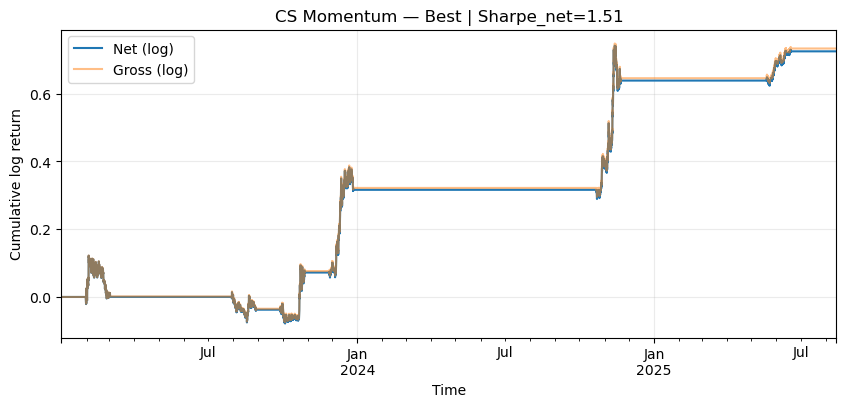

,best_combo
k,400.0000
band,2.5000
beta_win,NaN
every,720.0000
vol_win,NaN
sharpe_gross,1.5244
sharpe_net,1.5069
ann_ret_gross,0.2799
ann_ret_net,0.2767
ann_vol_gross,0.1836


In [36]:
w_best, net_best, gross_best = best
cum_net = net_best.fillna(0).cumsum()
cum_gross = gross_best.fillna(0).cumsum()

fig, ax = plt.subplots(1, 1, figsize=(10,4))
cum_net.plot(ax=ax, label="Net (log)")
cum_gross.plot(ax=ax, label="Gross (log)", alpha=0.5)
ax.set_title(f"CS Momentum — Best | Sharpe_net={best_meta['sharpe_net']:.2f}")
ax.set_xlabel("Time"); ax.set_ylabel("Cumulative log return")
ax.legend(); ax.grid(True, alpha=0.25)
plt.show()

display(pd.Series(best_meta).to_frame("best_combo"))

In [38]:
split_date = ret.index[int(len(ret)*0.7)]
R_tr, R_te = ret.loc[:split_date], ret.loc[split_date:]

w_full = cs_momentum_weights(ret, k=best_meta["k"], band=best_meta["band"],
                             beta_win=best_meta["beta_win"], bench=BENCH, vol_win=best_meta["vol_win"])
w_full = downsample_weights(w_full, every=best_meta["every"])
net_full, _, _ = backtest(w_full, ret, cost_rate=COST_RATE)

st_tr, st_te = perf_stats(net_full.loc[R_tr.index]), perf_stats(net_full.loc[R_te.index])
print("Train:", st_tr); print("Test :", st_te)
display(pd.DataFrame([st_tr, st_te], index=["Train","Test"]))

Train: {'ann_ret': 0.22099989423161395, 'ann_vol': 0.17761902258652953, 'sharpe': 1.2442355048088998}
Test : {'ann_ret': 0.4105494973184481, 'ann_vol': 0.19696944910820766, 'sharpe': 2.0843308400223406}


,ann_ret,ann_vol,sharpe
Train,0.221000,0.177619,1.244236
Test,0.410549,0.196969,2.084331


Expanding — mean test Sharpe: 3.67 | median: 3.67
Rolling   — mean test Sharpe: 3.67 | median: 3.67


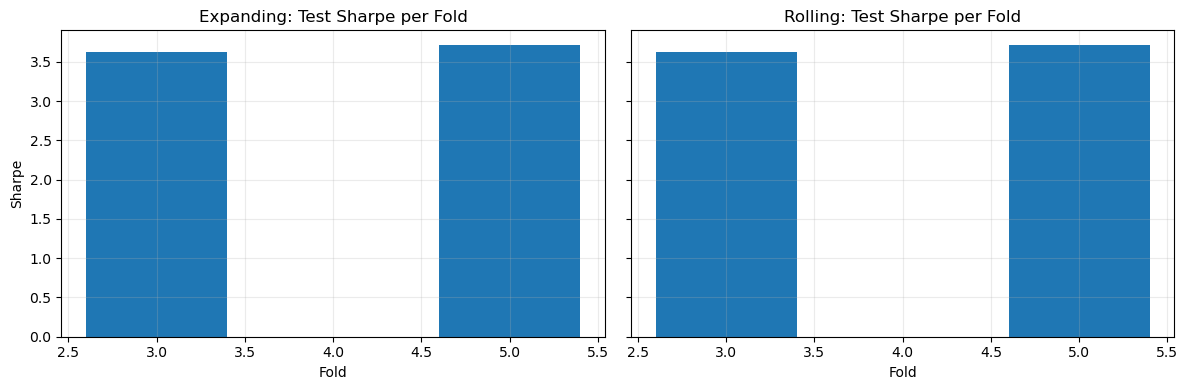

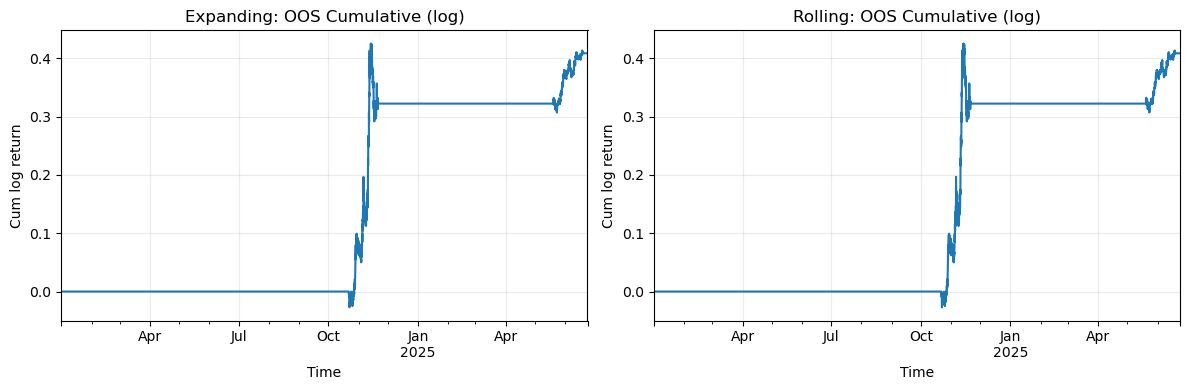

In [39]:
# Best momentum params from your sweep
best_params_mom = {k: best_meta[k] for k in ["k","band","beta_win","every","vol_win"]}

# Expanding
cfg_exp = WFConfig(train_days=365, test_days=90, mode="expanding")
exp_df, exp_test_net = run_walk_forward(
    ret, best_params_mom, cost_bps=COST_BPS, cfg=cfg_exp, weight_func=cs_momentum_weights
)

# Rolling
cfg_roll = WFConfig(train_days=365, test_days=90, mode="rolling")
roll_df, roll_test_net = run_walk_forward(
    ret, best_params_mom, cost_bps=COST_BPS, cfg=cfg_roll, weight_func=cs_momentum_weights
)

print(
    "Expanding — mean test Sharpe:", round(float(exp_df["test_sharpe"].mean()), 3),
    "| median:", round(float(exp_df["test_sharpe"].median()), 3)
)
print(
    "Rolling   — mean test Sharpe:", round(float(roll_df["test_sharpe"].mean()), 3),
    "| median:", round(float(roll_df["test_sharpe"].median()), 3)
)

# Bar charts: test Sharpe per fold
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
ax[0].bar(range(len(exp_df)), exp_df["test_sharpe"].values); ax[0].set_title("Expanding: Test Sharpe per Fold")
ax[0].set_xlabel("Fold"); ax[0].set_ylabel("Sharpe"); ax[0].grid(True, alpha=0.25)
ax[1].bar(range(len(roll_df)), roll_df["test_sharpe"].values); ax[1].set_title("Rolling: Test Sharpe per Fold")
ax[1].set_xlabel("Fold"); ax[1].grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

# Stitched OOS equity curves (log cum)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
exp_test_net.fillna(0).cumsum().plot(ax=ax[0]); ax[0].set_title("Expanding: OOS Cumulative (log)")
ax[0].set_xlabel("Time"); ax[0].set_ylabel("Cum log return"); ax[0].grid(True, alpha=0.25)
roll_test_net.fillna(0).cumsum().plot(ax=ax[1]); ax[1].set_title("Rolling: OOS Cumulative (log)")
ax[1].set_xlabel("Time"); ax[1].set_ylabel("Cum log return"); ax[1].grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

In [37]:
# Cost sensitivity
for bps in [7, 10, 20]:
    exp_df_bps, _  = run_walk_forward(
        ret, best_params_mom, cost_bps=bps, cfg=cfg_exp, weight_func=cs_momentum_weights
    )
    roll_df_bps, _ = run_walk_forward(
        ret, best_params_mom, cost_bps=bps, cfg=cfg_roll, weight_func=cs_momentum_weights
    )
    print(
        f"Cost {bps} bps → Exp mean test Sharpe={exp_df_bps['test_sharpe'].mean():.2f}, "
        f"Roll mean test Sharpe={roll_df_bps['test_sharpe'].mean():.2f}"
    )

# Nearby parameter perturbations
perturb = [
    {"k": best_meta["k"], "band": 2.0, "beta_win": best_meta["beta_win"], "every": best_meta["every"], "vol_win": best_meta["vol_win"]},
    {"k": best_meta["k"], "band": 3.0, "beta_win": best_meta["beta_win"], "every": best_meta["every"], "vol_win": best_meta["vol_win"]},

    {"k": 336, "band": best_meta["band"], "beta_win": best_meta["beta_win"], "every": best_meta["every"], "vol_win": best_meta["vol_win"]},
    {"k": 500, "band": best_meta["band"], "beta_win": best_meta["beta_win"], "every": best_meta["every"], "vol_win": best_meta["vol_win"]},
    {"k": 672, "band": best_meta["band"], "beta_win": best_meta["beta_win"], "every": best_meta["every"], "vol_win": best_meta["vol_win"]},

    {"k": best_meta["k"], "band": best_meta["band"], "beta_win": best_meta["beta_win"], "every": 336, "vol_win": best_meta["vol_win"]},
    {"k": best_meta["k"], "band": best_meta["band"], "beta_win": best_meta["beta_win"], "every": 960, "vol_win": best_meta["vol_win"]},
]

rows = []
for p in perturb:
    df_exp_p, _  = run_walk_forward(ret, p, cost_bps=COST_BPS, cfg=cfg_exp,  weight_func=cs_momentum_weights)
    df_roll_p, _ = run_walk_forward(ret, p, cost_bps=COST_BPS, cfg=cfg_roll, weight_func=cs_momentum_weights)
    rows.append({
        **p,
        "exp_mean_test_sharpe":   float(df_exp_p["test_sharpe"].mean()),
        "roll_mean_test_sharpe":  float(df_roll_p["test_sharpe"].mean()),
        "exp_median_test_sharpe": float(df_exp_p["test_sharpe"].median()),
        "roll_median_test_sharpe":float(df_roll_p["test_sharpe"].median()),
    })

perturb_df = pd.DataFrame(rows).sort_values(
    ["exp_mean_test_sharpe", "roll_mean_test_sharpe"], ascending=False
)
print("\nParameter perturbation — mean test Sharpe across folds:")
display(perturb_df.round(3))

Cost 7 bps → Exp mean test Sharpe=3.67, Roll mean test Sharpe=3.67
Cost 10 bps → Exp mean test Sharpe=3.65, Roll mean test Sharpe=3.65
Cost 20 bps → Exp mean test Sharpe=3.60, Roll mean test Sharpe=3.60

Parameter perturbation — mean test Sharpe across folds:


,k,band,beta_win,every,vol_win,exp_mean_test_sharpe,roll_mean_test_sharpe,exp_median_test_sharpe,roll_median_test_sharpe
3,500,2.5000,None,720,None,3.6240,3.6240,3.6240,3.6240
4,672,2.5000,None,720,None,3.6240,3.6240,3.6240,3.6240
2,336,2.5000,None,720,None,3.6240,3.6240,3.6240,3.6240
0,400,2.0000,None,720,None,0.1630,0.1630,-0.3360,-0.3360
5,400,2.5000,None,336,None,-0.0170,-0.0130,-0.0170,-0.0130
6,400,2.5000,None,960,None,-4.6510,-1.8240,-4.6510,-1.8240
1,400,3.0000,None,720,None,NaN,NaN,NaN,NaN


In [38]:
# 1) How many folds?
print("Expanding folds:", len(exp_df))
print("Rolling folds:  ", len(roll_df))

# 2) Newey–West t-stat on stitched OOS returns
oos_exp  = exp_test_net.dropna()
oos_roll = roll_test_net.dropna()

# Choose HAC lag ≈ holding period (bars)
lag_bars = int(best_params_mom["every"])
lag_bars = max(1, min(lag_bars, len(oos_exp)//3))

mu_exp, t_exp = nw_tstat_mean(oos_exp.values,  lag_bars)
mu_roll, t_roll = nw_tstat_mean(oos_roll.values, lag_bars)

print(f"\nHAC lag (bars): {lag_bars}")
print(f"Expanding OOS: mean={mu_exp:.6f} per bar, NW t={t_exp:.2f}")
print(f"Rolling  OOS: mean={mu_roll:.6f} per bar, NW t={t_roll:.2f}")

Expanding folds: 6
Rolling folds:   6

HAC lag (bars): 720
Expanding OOS: mean=0.000032 per bar, NW t=1.37
Rolling  OOS: mean=0.000032 per bar, NW t=1.37


In [39]:
# --- Benchmark hourly returns (BTC) ---
bench_ret = ret["BTCUSDT"] if "BTCUSDT" in ret.columns else ret.mean(axis=1)

# --- Stitched OOS series ---
oos_series = {
    "Expanding OOS": exp_test_net,   # stitched OOS net returns
    "Rolling OOS":   roll_test_net,
}

# HAC lag
hac_lag = int(best_meta.get("every", 720))

rows = []
for label, r in oos_series.items():
    res = compute_alpha_beta(r, bench_ret, freq=24*365, lag_bars=hac_lag)
    res["label"] = label
    rows.append(res)

alpha_beta_df = pd.DataFrame(rows).set_index("label")
display(alpha_beta_df.round(3))

,alpha_ann,alpha_t,beta,beta_t,R2,n_obs
label,,,,,,
Expanding OOS,0.2590,1.4140,0.0280,1.1480,0.0080,12960
Rolling OOS,0.2590,1.4140,0.0280,1.1480,0.0080,12960


### Alpha/Beta Analysis

We regress the out-of-sample (OOS) returns of the momentum strategy on BTCUSDT as a benchmark. Results:

| Label        | alpha_ann | alpha_t | beta  | beta_t | R²    | n_obs |
|--------------|-----------|---------|-------|--------|-------|-------|
| Expanding OOS | 0.2590    | 1.414   | 0.028 | 1.148  | 0.008 | 12960 |
| Rolling OOS   | 0.2590    | 1.414   | 0.028 | 1.148  | 0.008 | 12960 |

**Interpretation:** The strategy delivers an annualized alpha of ~0.26, but the statistical evidence is weak (t ≈ 1.41, below the 5% significance threshold of 1.96). Market exposure is minimal (β ≈ 0.03, not significant), with almost no explanatory power from BTC (R² < 1%). Overall, the strategy appears to generate idiosyncratic returns largely uncorrelated with the benchmark.